# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [10]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions

In [11]:

from jaxns import Prior, Model, Bernoulli

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p)
    return predicates, p[1]


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & 0.6 <= P(b) <= 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    #0.6 <= P(b) <= 0.9
    log_prob_1 = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9))
    log_prob_2 = jnp.where((p_B < 0.6) | (p_B > 0.9), -jnp.inf, 0.)
    log_prop = log_prob_1 + log_prob_2

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2024-01-10 00:53:07,631]: Sanity check...
INFO[2024-01-10 00:53:07,638]: Sanity check passed


In [12]:
import jax
from jaxns import NestedSampler

# Run the nested sampling
ns = NestedSampler(model=model, max_samples=1e5, c=1000, difficult_model=True, parameter_estimation=True)

term_reason, state = jax.jit(ns)(random.PRNGKey(3452345))
results = ns.to_results(termination_reason=term_reason, state=state)

--------
Termination Conditions:
Small remaining evidence
All live-points are on a single plateau (potential numerical errors, consider 64-bit)
--------
likelihood evals: 7340
samples: 2000
phantom samples: 0
likelihood evals / sample: 3.7
phantom fraction (%): 0.0%
--------
logZ=-0.386 +- 0.015
H=-0.19
ESS=541
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.46 +- 0.28 | 0.08 / 0.42 / 0.89 | 0.99 | 0.22
p[1]: 0.748 +- 0.088 | 0.629 / 0.749 / 0.871 | 0.862 | 0.871
p[2]: 0.54 +- 0.3 | 0.1 / 0.55 / 0.93 | 0.99 | 0.93
--------


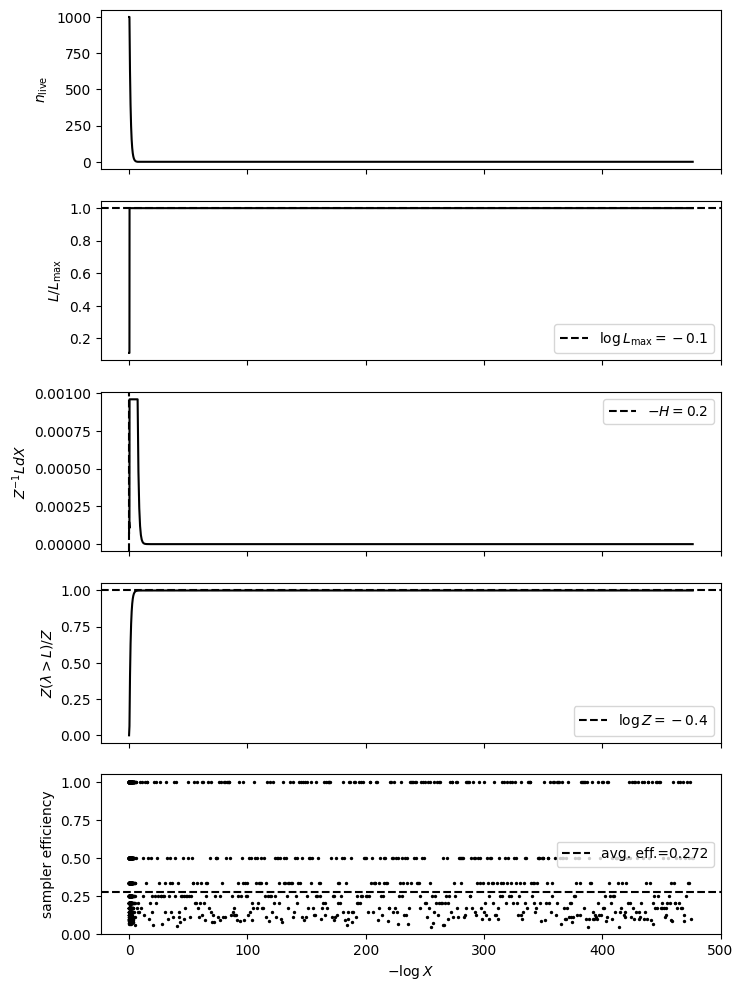

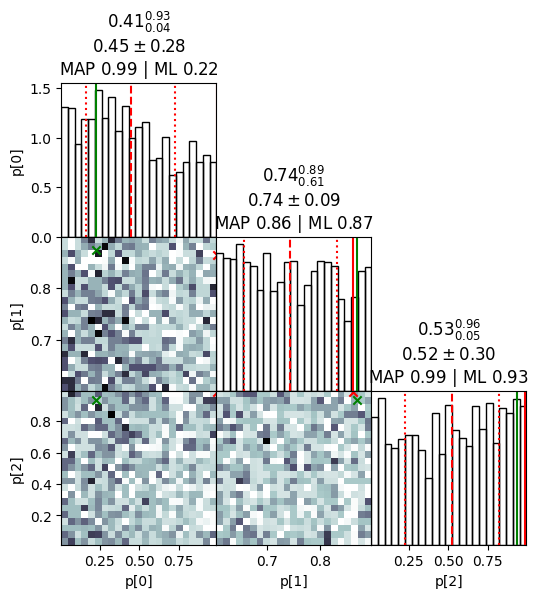

In [13]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)